<a href="https://colab.research.google.com/github/Jpiramos/ia01_exercProp03/blob/main/Exerc%C3%ADcio_Pr%C3%A1tico_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Definir transformações para o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Achatar a imagem para 784 valores
])

# Baixar o dataset MNIST
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Dividir dataset em treino e teste
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.23MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



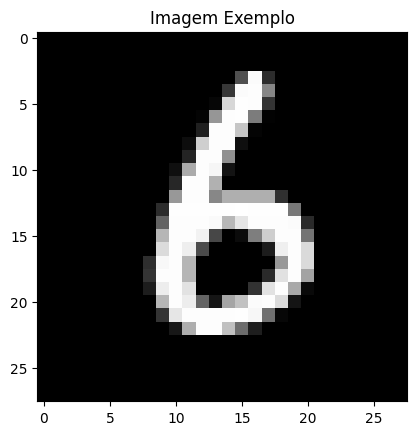

In [2]:
# Criar DataLoader para carregar os dados em batches
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Visualizar uma imagem a partir de um vetor de 784 valores
def show_image_from_vector(data_loader):
    image_vector, label = next(iter(data_loader))
    image_vector = image_vector[0]  # Pegue apenas a primeira imagem do batch
    image_reshaped = image_vector.view(28, 28)  # Reformatar para 28x28
    plt.imshow(image_reshaped, cmap='gray')
    plt.title(f'Imagem Exemplo')
    plt.show()

# Mostrar a imagem antes do treinamento
show_image_from_vector(train_loader)

In [3]:
# Definir um modelo de rede neural totalmente conectado com melhorias
class EnhancedFullyConnectedNN(nn.Module):
    def __init__(self):
        super(EnhancedFullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)      # Camada de entrada
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)          # Primeira camada oculta
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)          # Segunda camada oculta
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)           # Camada de saída
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # Saída sem ativação, CrossEntropyLoss cuida disso
        return x

# Instanciar o modelo, definir a função de perda e o otimizador
model = EnhancedFullyConnectedNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Taxa de aprendizado menor


In [4]:
# Função para treinar o modelo
def train_model(model, train_loader, test_loader, criterion, optimizer, max_epochs=50, patience=5):
    train_losses = []
    test_losses = []
    min_train_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Limpar gradientes acumulados
            outputs = model(images)  # Fazer previsões
            loss = criterion(outputs, labels)  # Calcular perda
            loss.backward()  # Retropropagação
            optimizer.step()  # Atualizar os pesos
            running_loss += loss.item()

        # Calcular perda média no treino
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calcular perda no conjunto de teste
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Verificar se a perda de treino não está diminuindo
        if avg_train_loss < min_train_loss:
            min_train_loss = avg_train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Parando o treinamento após {epoch+1} épocas devido à estagnação na perda.")
            break

    return train_losses, test_losses


Epoch [1/50], Loss: 0.3372, Test Loss: 0.1172
Epoch [2/50], Loss: 0.1491, Test Loss: 0.0840
Epoch [3/50], Loss: 0.1099, Test Loss: 0.0808
Epoch [4/50], Loss: 0.0941, Test Loss: 0.0694
Epoch [5/50], Loss: 0.0819, Test Loss: 0.0700
Epoch [6/50], Loss: 0.0735, Test Loss: 0.0633
Epoch [7/50], Loss: 0.0665, Test Loss: 0.0719
Epoch [8/50], Loss: 0.0590, Test Loss: 0.0597
Epoch [9/50], Loss: 0.0542, Test Loss: 0.0653
Epoch [10/50], Loss: 0.0528, Test Loss: 0.0637
Epoch [11/50], Loss: 0.0477, Test Loss: 0.0596
Epoch [12/50], Loss: 0.0451, Test Loss: 0.0562
Epoch [13/50], Loss: 0.0413, Test Loss: 0.0609
Epoch [14/50], Loss: 0.0394, Test Loss: 0.0569
Epoch [15/50], Loss: 0.0364, Test Loss: 0.0592
Epoch [16/50], Loss: 0.0346, Test Loss: 0.0535
Epoch [17/50], Loss: 0.0345, Test Loss: 0.0594
Epoch [18/50], Loss: 0.0324, Test Loss: 0.0578
Epoch [19/50], Loss: 0.0298, Test Loss: 0.0554
Epoch [20/50], Loss: 0.0285, Test Loss: 0.0571
Epoch [21/50], Loss: 0.0279, Test Loss: 0.0548
Epoch [22/50], Loss: 0

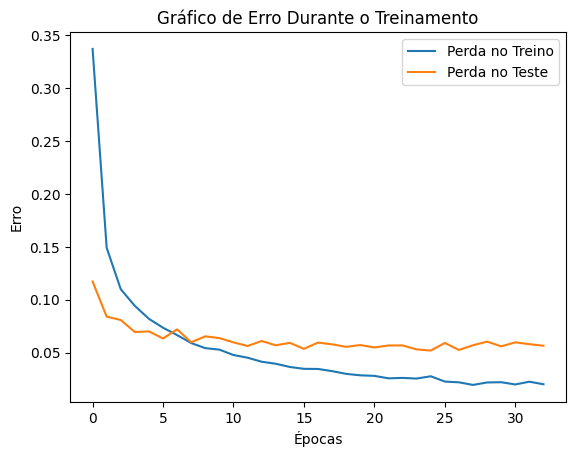

In [5]:
# Treinar o modelo e plotar os gráficos de erro
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer)

# Função para plotar os gráficos de erro
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label="Perda no Treino")
    plt.plot(test_losses, label="Perda no Teste")
    plt.xlabel("Épocas")
    plt.ylabel("Erro")
    plt.legend()
    plt.title("Gráfico de Erro Durante o Treinamento")
    plt.show()

plot_losses(train_losses, test_losses)


In [6]:
# Função para calcular a precisão (percentual de acertos) do modelo
def calculate_accuracy(model, data_loader):
    model.eval()  # Colocar o modelo em modo de avaliação
    correct = 0
    total = 0
    with torch.no_grad():  # Desligar o cálculo de gradientes para avaliação
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Obter a classe com maior probabilidade
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Contar quantos acertos tivemos
    accuracy = 100 * correct / total
    return accuracy

# Calcular e exibir a precisão no conjunto de treino e de teste
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)

print(f'Acurácia no conjunto de treino: {train_accuracy:.2f}%')
print(f'Acurácia no conjunto de teste: {test_accuracy:.2f}%')

Acurácia no conjunto de treino: 99.96%
Acurácia no conjunto de teste: 98.50%
